In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi

In [3]:
kuaizi.set_matplotlib(style='nature', usetex=False, dpi=100)
kuaizi.set_env(project='popsed', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/popsed/'

In [4]:
import fsps
import sedpy
from sedpy.observate import load_filters
import prospect
from prospect.sources.constants import cosmo
import exspect
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')

In [5]:
from popsed import mock
from popsed.sfh import params_to_sfh, parametric_sfr, parametric_mwa

In [6]:
# SDSS filters
sdss = ['sdss_{0}0'.format(b) for b in 'ugriz']

### Let's think about the prior distributions for sampling traning SEDs

$\log\, M_\star\ [M_\odot] \sim \rm Uniform[9.0, 12.0, 0.1]$ (fast, **don't need to include in the emulator**)

$t_{\rm age}\ [\rm Gyr] \sim \rm Uniform[0.5, t_{univ}(z), 0.4]$ (fast)

$\log\, \tau\ [\rm Gyr] \sim \rm Uniform[-2, 2, 0.2]$ (slow)

$z=0.05$ (we can try $z \sim \rm \mathcal{N}(0.1, 0.05^2)$ in the future)

In [8]:
import itertools

In [10]:
zred_set = np.array([0.05])
mass_set = np.array([1]) # Fix mass to 1 M_\odot #10**(np.linspace(9, 12, 20))
tage_set = np.linspace(1, float(cosmo.age(zred_set[0]).value), 40)
tau_set = 10**(np.arange(-2, 2, 0.1))

print('Total number of samples in parameter space:')
print(len(tau_set) * len(tage_set) * len(mass_set) * len(zred_set))

Total number of samples in parameter space:
1600


In [11]:
# Sample the stellar mass -- SFR plane
sfr_li = []
mass_li = []
mwa_li = []
tau_li = []
tage_li = []

for zred, mass, tage, tau in itertools.product(zred_set, mass_set, tage_set, tau_set):
    #print(np.log10(mass), tage, tau)
    model = mock.build_model(mass=mass, zred=zred, 
                             tage=tage, tau=tau, 
                             sfh=1, add_dustabs=False,
                             uniform_priors=True)
    sfr = parametric_sfr(times=np.array([0]), **model.params, tavg=0.05) # current SFR, t_avg = 50 Myr
    sfr_li.append(float(sfr))
    mass_li.append(mass)
    mwa_li.append(parametric_mwa(tau=tau, tage=cosmo.age(zred).value, power=0)) # power=0 for tau-model
    tau_li.append(tau)
    tage_li.append(tage)

Text(0, 0.5, '$\\log\\ \\mathrm{SFR}\\ [M_\\odot\\ \\rm{yr}^{-1}]$')

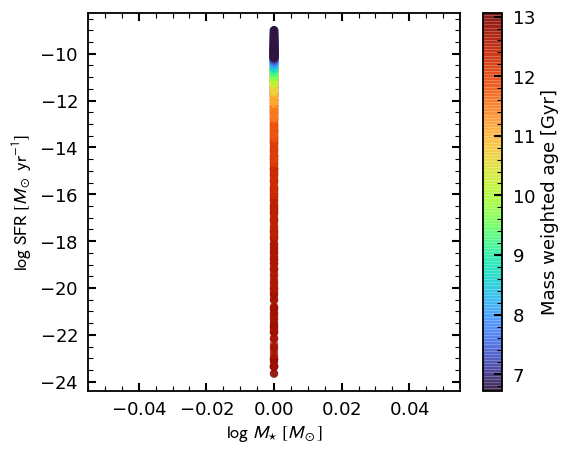

In [12]:
plt.scatter(np.log10(mass_li), np.log10(sfr_li), c=mwa_li, alpha=0.7, edgecolor='none')
plt.colorbar(label='Mass weighted age [Gyr]')
#plt.ylim(-4, 3)

plt.xlabel(r'$\log\ M_{\star}\ [M_\odot]$')
plt.ylabel(r'$\log\ \mathrm{SFR}\ [M_\odot\ \rm{yr}^{-1}]$')

#### Looks not bad? Try to generate some SEDs and benchmark the speed

In [17]:
sps = mock.build_sps(add_realism=False)

In [18]:
%%time
obs_set = []
# we start with a simple model: tau-SFH, no dust attenuation and emission, no nebular emission
for zred, mass, tage, tau in itertools.product(zred_set, mass_set, tage_set, tau_set):
    model = mock.build_model(mass=mass, zred=zred, logzsol=-0.5,
                             tage=tage, tau=tau, 
                             sfh=1, add_dustabs=False, 
                             uniform_priors=True)
    #sfr = parametric_sfr(times=np.array([0]), **model.params, tavg=0.05) # current SFR, t_avg = 50 Myr
    #model.params['sfr'] = sfr
    obs = mock.build_obs(sps, model, add_noise=True, # we use true_spectrum and true_mock for emulation
                         # Noise can be added afterward, with a better noise model
                         snr_spec=10, snr_phot=20,
                         filterset=sdss, 
                         continuum_optimize=False)
    obs_set.append(obs)

CPU times: user 1min 49s, sys: 7.46 s, total: 1min 56s
Wall time: 1min 58s


In [19]:
len(obs_set)

1600

In [20]:
with open('./train_sed/train_sed_1600.pkl', 'wb') as f:
    pickle.dump(obs_set, f)
    f.close()

## Load obs_set, and translate it into numpy arrays

In [50]:
with open('./train_sed/train_sed_1600.pkl', 'rb') as f:
    obs_set = pickle.load(f)
    f.close()

No handles with labels found to put in legend.


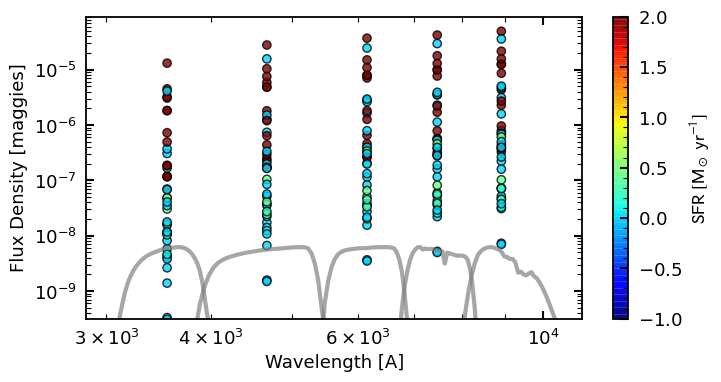

In [147]:
obs = obs_set[0]

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
plt.figure(figsize=(8, 4))

# plot all the data
for ob in np.array(obs_set)[np.random.randint(0, len(obs_set), 40)]:
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
#     sct = plt.scatter(wphot, ob['maggies'],
#          #label='All observed photometry',
#          marker='o', alpha=0.8, vmin=1, vmax=10,
#          c=np.ones_like(wphot) * ob['mock_params']['tau'], cmap='jet')
    sct = plt.scatter(wphot, ob['maggies'],
         #label='All observed photometry',
         marker='o', alpha=0.8, vmin=-1, vmax=2,
         c=np.ones_like(wphot) * sfr, cmap='jet')
    
plt.colorbar(sct, label=r'$\rm SFR\ [M_\odot\ yr^{-1}]$')
    
# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)
    
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin / 10, ymax * 1000])
#plt.xscale("log")
plt.yscale("log")
plt.legend(loc='best')

Text(0.5, 0.98, 'Randomly selected 80 SEDs in the traning sample')

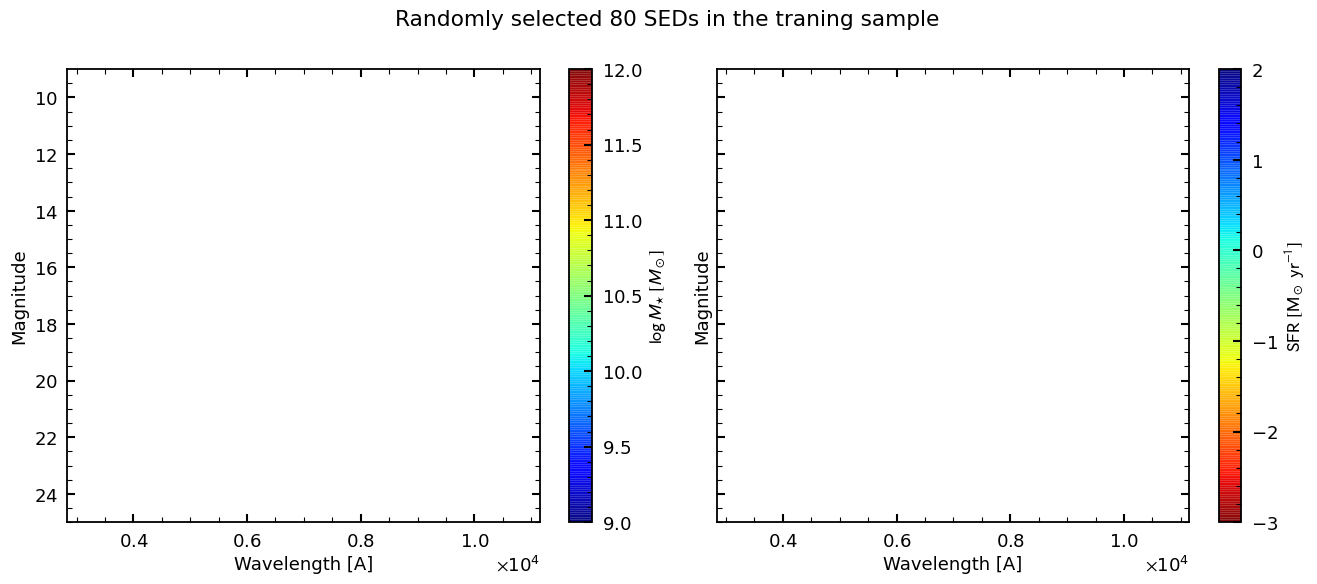

In [22]:
obs = obs_set[0]
wphot = obs["phot_wave"]
# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax =  -2.5 * np.log10(obs["maggies"].min())*0.8, -2.5 * np.log10(obs["maggies"].max())/0.4


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

plt.sca(axes[0])

# plot all the data
for ob in np.array(obs_set)[np.random.randint(0, len(obs_set), 80)]:
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
    sct = plt.scatter(wphot, -2.5 * np.log10(ob['maggies']),
         marker='o', alpha=0.8, vmin=9, vmax=12,
         c=np.ones_like(wphot) * np.log10(ob['mock_params']['mass']), cmap='jet')
plt.colorbar(sct, label=r'$\log\, M_{\star}\ [M_\odot]$')
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Magnitude')
plt.xlim([xmin, xmax])
plt.ylim([25, 9])

plt.sca(axes[1])
# plot all the data
for ob in np.array(obs_set)[np.random.randint(0, len(obs_set), 80)]:
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
    sct = plt.scatter(wphot, -2.5 * np.log10(ob['maggies']),
         #label='All observed photometry',
         marker='o', alpha=0.8, vmin=-3, vmax=2,
         c=np.ones_like(wphot) * np.log10(sfr), cmap='jet_r')
plt.colorbar(sct, label=r'$\rm SFR\ [M_\odot\ yr^{-1}]$')
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Magnitude')
plt.xlim([xmin, xmax])
plt.ylim([25, 9])


plt.suptitle('Randomly selected 80 SEDs in the traning sample')

In [232]:
# t, sfr, cmf = params_to_sfh(model.params, 
#                             time=np.linspace(0, cosmo.age(model.params['zred']).value, 30), 
#                             agebins=None)

## Translate the `obs_set` into numpy arrays of parameters, SEDs, and spectra

Spectrum: `dlambda_spec=2.0, wave_lo=3800, wave_hi=7000.0`. Length = 1600

`wavelength = np.arange(3800, 7000, 2)`.

Files are stored at `/scratch/gpfs/jiaxuanl/Data/popsed/train_sed`

In [51]:
obs = obs_set[10]
len_spec = len(obs['wavelength'])
len_phot = len(obs['phot_wave'])

In [52]:
%%time
# Array storing all spectra
spec_arr = np.zeros((len(obs_set), len_spec))
for i, obs in enumerate(obs_set):
    spec_arr[i] = np.log10(obs['true_spectrum'])
    
# Need to take log of the spectrum flux density

CPU times: user 93 ms, sys: 2.91 ms, total: 95.9 ms
Wall time: 95.4 ms


In [53]:
%%time
# Array storing all SEDs
phot_arr = np.zeros((len(obs_set), len_phot))
for i, obs in enumerate(obs_set):
    phot_arr[i] = obs['true_maggies']

CPU times: user 985 µs, sys: 1.91 ms, total: 2.89 ms
Wall time: 2.37 ms


In [54]:
list(obs['mock_params'].keys())

['zred',
 'mass',
 'logzsol',
 'dust2',
 'sfh',
 'tage',
 'imf_type',
 'dust_type',
 'tau']

In [55]:
keys = ['zred', 'mass', 'logzsol', 'dust2', 'sfh', 
        'tage', 'imf_type', 'dust_type', 'tau'] # , 'sfr'

In [56]:
%%time
param_arr = np.array([[float(obs['mock_params'][key]) for key in keys] for obs in obs_set])

param_arr[:, -1] = np.log10(param_arr[:, -1]) # tau to log(tau)

CPU times: user 8.62 ms, sys: 0 ns, total: 8.62 ms
Wall time: 8.49 ms


In [57]:
from sklearn.model_selection import train_test_split

In [67]:
with open('./train_sed/log_spec_all.npy', 'wb') as f:
    np.save(f, spec_arr)
    
with open('./train_sed/param_all.npy', 'wb') as f:
    np.save(f, param_arr)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(spec_arr, param_arr, test_size=0.20, random_state=42)

In [64]:
with open('./train_sed/log_spec_train.npy', 'wb') as f:
    np.save(f, X_train)
    
with open('./train_sed/log_spec_vali.npy', 'wb') as f:
    np.save(f, X_test)
    
with open('./train_sed/param_train.npy', 'wb') as f:
    np.save(f, y_train)
    
with open('./train_sed/param_vali.npy', 'wb') as f:
    np.save(f, y_test)

In [47]:
# with open('./train_sed/phot_1600.npy', 'wb') as f:
#     np.save(f, phot_arr)
    
# with open('./train_sed/log_spec_1600.npy', 'wb') as f:
#     np.save(f, spec_arr)
    
# with open('./train_sed/param_1600.npy', 'wb') as f:
#     np.save(f, param_arr)

**Galaxies with SFR=0 and very small $\tau$ ($\tau$ < 0.02) just have zero fluxes. Need to remove them??**

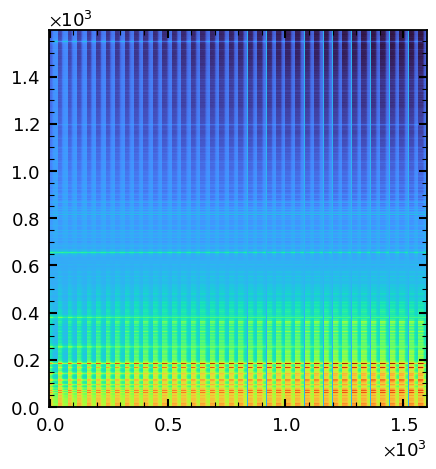

In [66]:
from astropy.visualization import simple_norm
test = spec_arr / np.mean(spec_arr, axis=1)[:, np.newaxis]
#norm = simple_norm(spec_arr / np.mean(spec_arr, axis=1)[:, np.newaxis], 'sqrt')
plt.imshow(test.T)#, norm=norm)